In [16]:
from gd_env import GeometryEnv
from model import Agent
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [17]:

# creamos el entorno y el agente

env = GeometryEnv()
state_size = len(env.get_state())
action_size = 2  # 0: no saltar, 1: saltar

agent = Agent(state_size, action_size)
episodes = 200
batch_size = 64

# Almacenar métricas
rewards_history = []
epsilon_history = []

for e in range(episodes):
    state = env.reset()
    total_reward = 0
    for t in range(1000):  # pasos por episodio
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        agent.replay(batch_size)
        if done:
            agent.update_target_model()
            break

    rewards_history.append(total_reward)
    epsilon_history.append(agent.epsilon)
    
    print("Ep", e + 1, "/", episodes, 
      "| Recompensa total:", round(total_reward, 2), 
      "| Epsilon:", round(agent.epsilon, 3))

# Guardar modelo
torch.save(agent.model.state_dict(), "geometry_dqn.pth")


Ep 1 / 200 | Recompensa total: -2.0 | Epsilon: 0.508
Ep 2 / 200 | Recompensa total: -5.0 | Epsilon: 0.306
Ep 3 / 200 | Recompensa total: -5.0 | Epsilon: 0.189
Ep 4 / 200 | Recompensa total: -5.0 | Epsilon: 0.121
Ep 5 / 200 | Recompensa total: -5.0 | Epsilon: 0.078
Ep 6 / 200 | Recompensa total: -5.0 | Epsilon: 0.05
Ep 7 / 200 | Recompensa total: -2.0 | Epsilon: 0.05
Ep 8 / 200 | Recompensa total: 5.0 | Epsilon: 0.05
Ep 9 / 200 | Recompensa total: -2.0 | Epsilon: 0.05
Ep 10 / 200 | Recompensa total: -5.0 | Epsilon: 0.05
Ep 11 / 200 | Recompensa total: -5.0 | Epsilon: 0.05
Ep 12 / 200 | Recompensa total: 19.0 | Epsilon: 0.05
Ep 13 / 200 | Recompensa total: -5.0 | Epsilon: 0.05
Ep 14 / 200 | Recompensa total: -2.0 | Epsilon: 0.05
Ep 15 / 200 | Recompensa total: 3.0 | Epsilon: 0.05
Ep 16 / 200 | Recompensa total: -2.0 | Epsilon: 0.05
Ep 17 / 200 | Recompensa total: -5.0 | Epsilon: 0.05
Ep 18 / 200 | Recompensa total: -5.0 | Epsilon: 0.05
Ep 19 / 200 | Recompensa total: -5.0 | Epsilon: 0.05

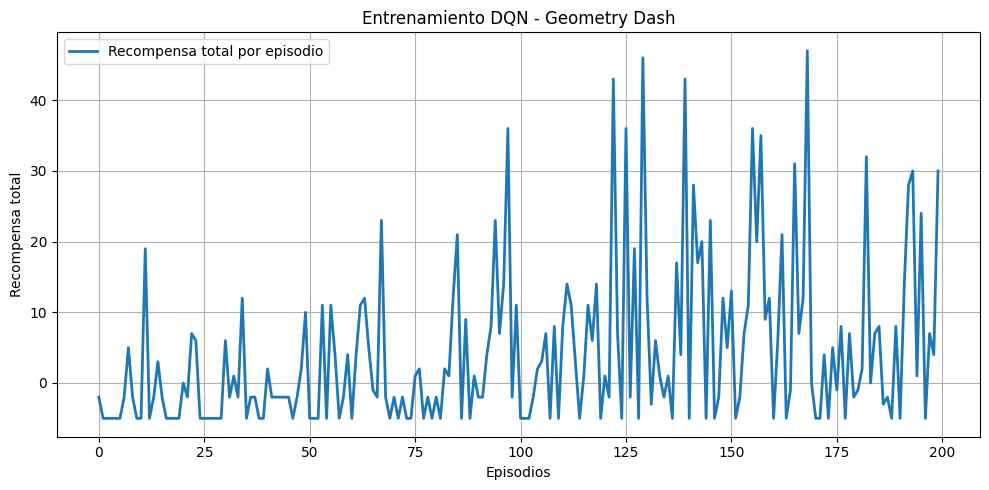

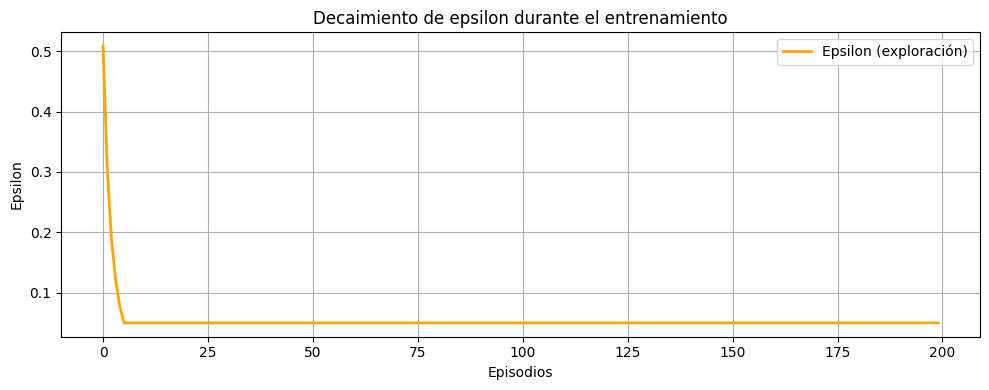

In [18]:
plt.figure(figsize=(10,5))
plt.plot(rewards_history, label="Recompensa total por episodio", linewidth=2)
plt.xlabel("Episodios")
plt.ylabel("Recompensa total")
plt.title("Entrenamiento DQN - Geometry Dash")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(epsilon_history, color="orange", label="Epsilon (exploración)", linewidth=2)
plt.xlabel("Episodios")
plt.ylabel("Epsilon")
plt.title("Decaimiento de epsilon durante el entrenamiento")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

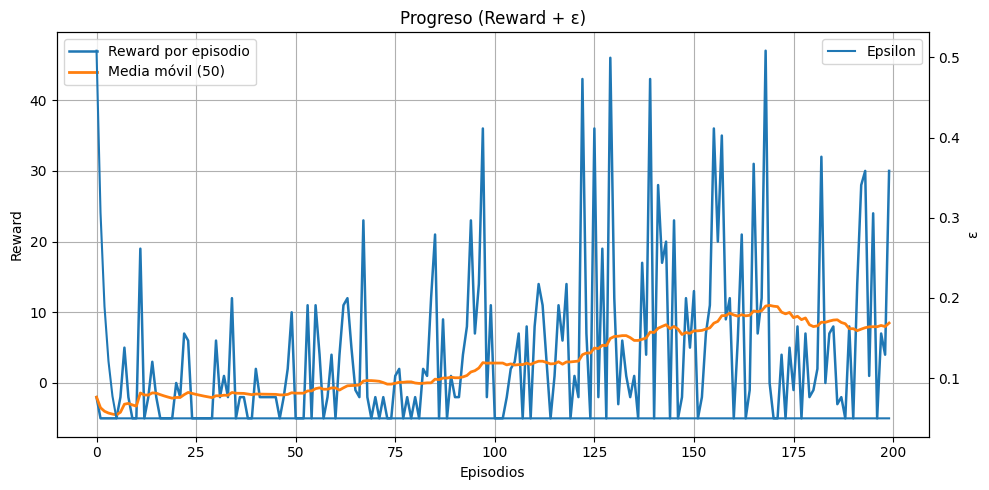

In [19]:
# Helpers y media móvil
from collections import deque

def moving_avg(seq, w=50):
    out, q, s = [], deque(), 0.0
    for v in seq:
        q.append(v); s += v
        if len(q) > w:
            s -= q.popleft()
        out.append(s/len(q))
    return out

# Gráfico extra: reward con media móvil + epsilon en eje secundario
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(rewards_history, label="Reward por episodio", linewidth=1.8)
ma = moving_avg(rewards_history, w=50)
if len(ma) == len(rewards_history):
    ax1.plot(ma, label="Media móvil (50)", linewidth=2)
ax1.set_xlabel("Episodios"); ax1.set_ylabel("Reward")
ax1.grid(True); ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(epsilon_history, label="Epsilon", linewidth=1.5)
ax2.set_ylabel("ε")
ax2.legend(loc="upper right")
plt.title("Progreso (Reward + ε)")
plt.tight_layout()
plt.show()


In [ ]:
import torch
import numpy as np

def eval_policy(model, episodes=20, epsilon=None):
    """
    model: agent.model (torch.nn.Module)
    epsilon=None → greedy puro; epsilon=1.0 → random puro; epsilon=0.05 → casi greedy, etc.
    """
    device = next(model.parameters()).device if any(p.requires_grad for p in model.parameters()) else "cpu"
    stats = {"reward": [], "length": [], "obstacles": []}
    for _ in range(episodes):
        e = GeometryEnv()
        s = e.reset()
        done = False
        ep_rew, ep_len, ep_obs = 0.0, 0, 0.0
        while not done:
            if epsilon is None:  # greedy puro
                with torch.no_grad():
                    q = model(torch.tensor(s, dtype=torch.float32).unsqueeze(0))
                    a = int(q.argmax(dim=1).item())
            else:
                if np.random.rand() < epsilon:
                    a = np.random.randint(0, 2)
                else:
                    with torch.no_grad():
                        q = model(torch.tensor(s, dtype=torch.float32).unsqueeze(0))
                        a = int(q.argmax(dim=1).item())

            s2, r, done, info = e.step(a)
            ep_rew += r; ep_len += 1
            if r > 0:   # si tu shaping es +1 por obstáculo, esto cuenta obstáculos
                ep_obs += r
            s = s2

        stats["reward"].append(ep_rew)
        stats["length"].append(ep_len)
        stats["obstacles"].append(ep_obs)

    return {k: (float(np.mean(v)), float(np.std(v))) for k,v in stats.items()}

# Ejecutar comparativa
rand_stats = eval_policy(agent.model, episodes=20, epsilon=1.0)
greedy_stats = eval_policy(agent.model, episodes=20, epsilon=None)

print("Random  -> reward(mean±sd):", rand_stats["reward"], " length:", rand_stats["length"], " obs:", rand_stats["obstacles"])
print("Greedy  -> reward(mean±sd):", greedy_stats["reward"], " length:", greedy_stats["length"], " obs:", greedy_stats["obstacles"])

# Barras simples (mean)
labels = ["Random","Greedy"]
means_reward = [rand_stats["reward"][0], greedy_stats["reward"][0]]
means_length = [rand_stats["length"][0], greedy_stats["length"][0]]

plt.figure(figsize=(8,4))
plt.bar(labels, means_reward)
plt.title("Reward medio: Random vs Greedy")
plt.ylabel("Reward medio"); plt.grid(True, axis="y"); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
plt.bar(labels, means_length)
plt.title("Longitud media: Random vs Greedy")
plt.ylabel("Pasos medios"); plt.grid(True, axis="y"); plt.tight_layout(); plt.show()


In [ ]:
qmax_por_ep = []
tto_jump, tto_nojump = [], []
vy_jump, vy_nojump = [], []

EP_EVAL = 10
for _ in range(EP_EVAL):
    e = GeometryEnv()
    s = e.reset()
    done = False
    qmax_acc = []
    while not done:
        # Q(s,·), acción greedy
        with torch.no_grad():
            q = agent.model(torch.tensor(s, dtype=torch.float32).unsqueeze(0))
            qvals = q.squeeze(0).numpy()
            a = int(np.argmax(qvals))
            qmax_acc.append(float(np.max(qvals)))

        # features del estado (ajusta si tu orden difiere)
        dist, vy, on_ground, tipo_idx, height_ratio, tto, land_dy, dist2, tipo2 = s

        s2, r, done, info = e.step(a)

        if a == 1:
            tto_jump.append(float(tto))
            vy_jump.append(float(vy))
        else:
            tto_nojump.append(float(tto))
            vy_nojump.append(float(vy))

        s = s2

    qmax_por_ep.append(np.mean(qmax_acc) if qmax_acc else np.nan)

# Gráficos
plt.figure(figsize=(8,4))
plt.plot(qmax_por_ep, marker="o")
plt.title("q_max promedio por episodio (greedy)")
plt.xlabel("Episodio de evaluación"); plt.ylabel("q_max medio"); plt.grid(True); plt.tight_layout(); plt.show()

if len(tto_jump)>0 and len(tto_nojump)>0:
    plt.figure(figsize=(8,4))
    plt.hist(tto_jump, bins=30, alpha=0.6, label="action=1 (jump)")
    plt.hist(tto_nojump, bins=30, alpha=0.6, label="action=0 (no-jump)")
    plt.title("Distribución time_to_obstacle por acción (greedy)")
    plt.xlabel("time_to_obstacle"); plt.ylabel("conteo"); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

if len(vy_jump)>0 and len(vy_nojump)>0:
    plt.figure(figsize=(8,4))
    plt.hist(vy_jump, bins=30, alpha=0.6, label="action=1 (jump)")
    plt.hist(vy_nojump, bins=30, alpha=0.6, label="action=0 (no-jump)")
    plt.title("Distribución vy por acción (greedy)")
    plt.xlabel("vy"); plt.ylabel("conteo"); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


In [ ]:
import pandas as pd

# A nivel episodio (del entreno que ya hiciste)
df_epi = pd.DataFrame({
    "episode": np.arange(1, len(rewards_history)+1),
    "reward": rewards_history,
    "epsilon": epsilon_history
})
df_epi.to_csv("logs_episodios.csv", index=False)

# A nivel evaluación (random vs greedy)
df_eval = pd.DataFrame({
    "policy": ["random","greedy"],
    "reward_mean": [rand_stats["reward"][0], greedy_stats["reward"][0]],
    "reward_std":  [rand_stats["reward"][1], greedy_stats["reward"][1]],
    "length_mean": [rand_stats["length"][0], greedy_stats["length"][0]],
    "length_std":  [rand_stats["length"][1], greedy_stats["length"][1]]
})
df_eval.to_csv("eval_runs.csv", index=False)

print("CSV guardados: logs_episodios.csv, eval_runs.csv")
